In [19]:
import pandas as pd
import numpy as np
import io
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

SEQ_LENGTH = 24
N_FEATURES = 4

def intelligent_loader(filename, content):
    try:
        df = pd.read_csv(io.BytesIO(content))
        if all(col in df.columns for col in ['year', 'month', 'day', 'hour']):
            df['Date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        else:
            date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
            df['Date'] = pd.to_datetime(df[date_cols[0]])
        df = df.set_index('Date').sort_index()

        target_cols = [c for c in df.columns if any(k in c.lower() for k in ['pm', 'pollution', 'aqi'])]
        df['Target_Label'] = df[target_cols].mean(axis=1)

        df_numeric = df.select_dtypes(include=[np.number])
        cols_to_drop = target_cols + ['No', 'year', 'month', 'day', 'hour']
        df_final = df_numeric.drop(columns=[c for c in cols_to_drop if c in df_numeric.columns], errors='ignore')

        cols = ['Target_Label'] + [c for c in df_final.columns if c != 'Target_Label']
        df_final = df_final[cols].interpolate(method='linear', limit=12).dropna()
        return df_final
    except:
        return None

print("📥 Please Upload your 4 DATASETS...")
uploaded = files.upload()
dfs = [intelligent_loader(k, v) for k,v in uploaded.items() if intelligent_loader(k, v) is not None]
full_df = pd.concat(dfs).sort_index()

X_sample = full_df.iloc[:, 1:]
y_sample = full_df.iloc[:, 0]
selector = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
selector.fit(X_sample, y_sample)
top_features = pd.Series(selector.feature_importances_, index=X_sample.columns).nlargest(N_FEATURES).index.tolist()

full_df = full_df[['Target_Label'] + top_features]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(full_df)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LENGTH)

# 60% Train, 15% Val, 10% Test (Remaining 15% is absorbed buffer)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.20, shuffle=False)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"\n📊 DATA SPLIT COMPLETE:")
print(f"Training: {len(X_train)} | Validation: {len(X_val)} | Final Test: {len(X_test)}")

📥 Please Upload your 4 DATASETS...


Saving pollution.csv.csv to pollution.csv (2).csv

📊 DATA SPLIT COMPLETE:
Training: 10361 | Validation: 2591 | Final Test: 1440


In [20]:
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

print("TRAINING MODELS")

# 1. Random Forest
best_rf = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
best_rf.fit(X_train_flat, y_train)

# 2. XGBoost
best_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, n_jobs=-1)
best_xgb.fit(X_train_flat, y_train)

# 3. LSTM
model = Sequential([
    Input(shape=(SEQ_LENGTH, X_train.shape[2])),
    LSTM(64, return_sequences=True), Dropout(0.2),
    LSTM(32), Dropout(0.2),
    Dense(16, activation='relu'), Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=15, batch_size=128, callbacks=[early_stop], verbose=1)

print("TRAINING COMPLETE.")

⚡ TRAINING MODELS...
Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0121 - val_loss: 0.0020
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0018 - val_loss: 9.3672e-04
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0018 - val_loss: 8.2423e-04
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0014 - val_loss: 7.1076e-04
Epoch 9/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0014 - val_loss: 6.8537e-04
Epoch 10/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0011 - val_loss: 6.0652e-04
Epoch 11/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0013 - val_loss: 6.8881e-04
Epoch 12/15
81/81 

📊 GENERATING FINAL EVALUATION ON 10% TEST SET...

--- REGRESSION METRICS ---
        Model      MSE     RMSE      MAE  R2 Score
Random Forest 0.000325 0.018036 0.012017  0.933304
      XGBoost 0.000350 0.018698 0.012215  0.928314
         LSTM 0.000422 0.020553 0.014473  0.913386


/tmp/ipython-input-2964777572.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2 Score", data=results_df, ax=ax4, palette="magma")


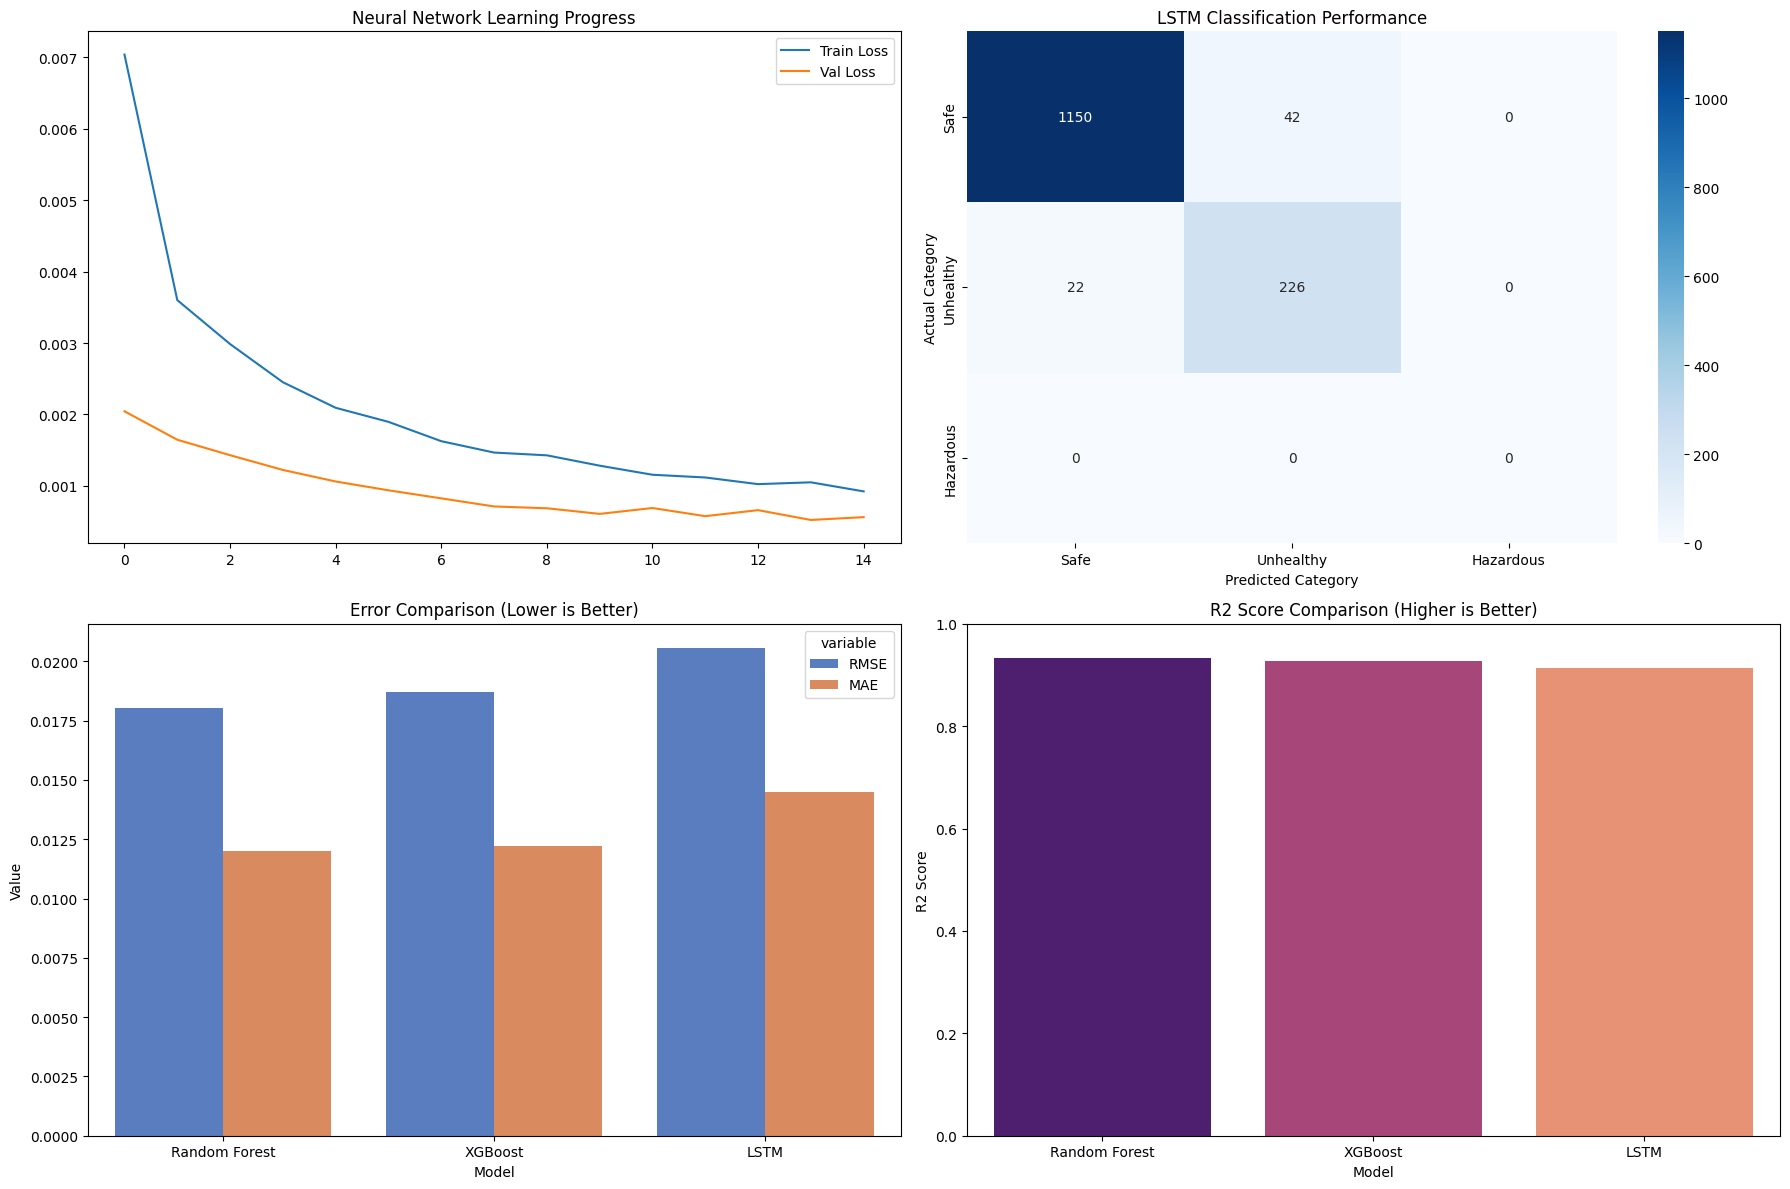

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np

print("GENERATING FINAL EVALUATION ON 10% TEST SET")

# 1. Generate Predictions
rf_p = best_rf.predict(X_test_flat)
xgb_p = best_xgb.predict(X_test_flat)
lstm_p = model.predict(X_test, verbose=0).flatten()

# 2. Build Regression Metrics Table
metrics_data = []
for name, pred in [("Random Forest", rf_p), ("XGBoost", xgb_p), ("LSTM", lstm_p)]:
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    metrics_data.append({"Model": name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2 Score": r2})

results_df = pd.DataFrame(metrics_data)
print("\n--- REGRESSION METRICS ---")
print(results_df.to_string(index=False))

# 3. Categorization for Confusion Matrix
def categorize_pm(data):
    return np.where(data < 0.15, "Safe",
           np.where(data < 0.45, "Unhealthy", "Hazardous"))

y_actual_cat = categorize_pm(y_test)
y_pred_cat = categorize_pm(lstm_p)


fig = plt.figure(figsize=(18, 12))

# Subplot 1: Learning Curves
ax1 = plt.subplot(2, 2, 1)
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Neural Network Learning Progress')
ax1.legend()

# Subplot 2: Confusion Matrix
ax2 = plt.subplot(2, 2, 2)
labels = ["Safe", "Unhealthy", "Hazardous"]
cm = confusion_matrix(y_actual_cat, y_pred_cat, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=labels, yticklabels=labels)
ax2.set_title('LSTM Classification Performance')
ax2.set_ylabel('Actual Category')
ax2.set_xlabel('Predicted Category')

# Subplot 3: Bar Chart Comparison (RMSE & MAE)
ax3 = plt.subplot(2, 2, 3)
melted_df = results_df.melt(id_vars="Model", value_vars=["RMSE", "MAE"])
sns.barplot(x="Model", y="value", hue="variable", data=melted_df, ax=ax3, palette="muted")
ax3.set_title('Error Comparison (Lower is Better)')
ax3.set_ylabel('Value')

# Subplot 4: Bar Chart Comparison (R2 Score)
ax4 = plt.subplot(2, 2, 4)
sns.barplot(x="Model", y="R2 Score", data=results_df, ax=ax4, palette="magma")
ax4.set_title('R2 Score Comparison (Higher is Better)')
ax4.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

🔮 GENERATING 30-DAY FUTURE FORECAST...


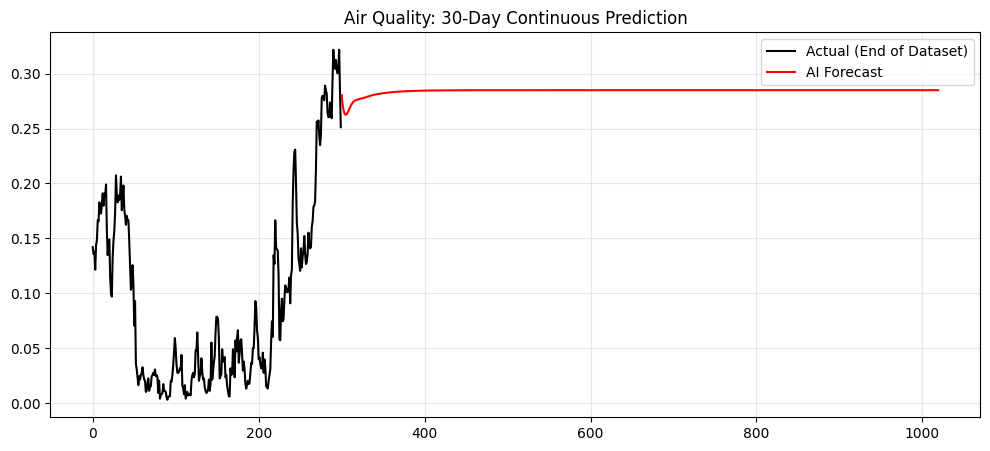

In [22]:

current_batch = X_test[-1].reshape((1, SEQ_LENGTH, X_test.shape[2]))
future_preds = []

for _ in range(24 * 30):
    p = model.predict(current_batch, verbose=0)[0, 0]
    future_preds.append(p)
    new_row = current_batch[0, -1, :].copy()
    new_row[0] = p # Update target feature
    current_batch = np.append(current_batch[:, 1:, :], new_row.reshape(1,1,-1), axis=1)

plt.figure(figsize=(12, 5))
plt.plot(range(300), y_test[-300:], label='Actual (End of Dataset)', color='black')
plt.plot(range(300, 300+len(future_preds)), future_preds, label='AI Forecast', color='red')
plt.title("Air Quality: 30-Day Continuous Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()